<a href="https://colab.research.google.com/github/syedbabart/convLSTM-covid19/blob/master/Independent_convLSTMs_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Input
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel(r'/new_cases_Pakistan.xlsx')
df_deaths = pd.read_excel(r'/new_deaths_Pakistan.xlsx')

In [3]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244
date,2019-12-31 00:00:00,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00,2020-01-05 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-11 00:00:00,2020-01-12 00:00:00,2020-01-13 00:00:00,2020-01-14 00:00:00,2020-01-15 00:00:00,2020-01-16 00:00:00,2020-01-17 00:00:00,2020-01-18 00:00:00,2020-01-19 00:00:00,2020-01-20 00:00:00,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,...,2020-07-23 00:00:00,2020-07-24 00:00:00,2020-07-25 00:00:00,2020-07-26 00:00:00,2020-07-27 00:00:00,2020-07-28 00:00:00,2020-07-29 00:00:00,2020-07-30 00:00:00,2020-07-31 00:00:00,2020-08-01 00:00:00,2020-08-02 00:00:00,2020-08-03 00:00:00,2020-08-04 00:00:00,2020-08-05 00:00:00,2020-08-06 00:00:00,2020-08-07 00:00:00,2020-08-08 00:00:00,2020-08-09 00:00:00,2020-08-10 00:00:00,2020-08-11 00:00:00,2020-08-12 00:00:00,2020-08-13 00:00:00,2020-08-14 00:00:00,2020-08-15 00:00:00,2020-08-16 00:00:00,2020-08-17 00:00:00,2020-08-18 00:00:00,2020-08-19 00:00:00,2020-08-20 00:00:00,2020-08-21 00:00:00,2020-08-22 00:00:00,2020-08-23 00:00:00,2020-08-24 00:00:00,2020-08-25 00:00:00,2020-08-26 00:00:00,2020-08-27 00:00:00,2020-08-28 00:00:00,2020-08-29 00:00:00,2020-08-30 00:00:00,2020-08-31 00:00:00
New Cases in Pakistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1763,1209,1487,1226,1176,936,1063,1114,903,0,0,1724,432,675,727,782,842,634,539,531,730,753,626,747,670,498,617,0,1126,630,586,591,0,946,482,445,415,319,264,213


In [4]:
df_deaths.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244
date,2019-12-31 00:00:00,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00,2020-01-05 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,2020-01-11 00:00:00,2020-01-12 00:00:00,2020-01-13 00:00:00,2020-01-14 00:00:00,2020-01-15 00:00:00,2020-01-16 00:00:00,2020-01-17 00:00:00,2020-01-18 00:00:00,2020-01-19 00:00:00,2020-01-20 00:00:00,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,...,2020-07-23 00:00:00,2020-07-24 00:00:00,2020-07-25 00:00:00,2020-07-26 00:00:00,2020-07-27 00:00:00,2020-07-28 00:00:00,2020-07-29 00:00:00,2020-07-30 00:00:00,2020-07-31 00:00:00,2020-08-01 00:00:00,2020-08-02 00:00:00,2020-08-03 00:00:00,2020-08-04 00:00:00,2020-08-05 00:00:00,2020-08-06 00:00:00,2020-08-07 00:00:00,2020-08-08 00:00:00,2020-08-09 00:00:00,2020-08-10 00:00:00,2020-08-11 00:00:00,2020-08-12 00:00:00,2020-08-13 00:00:00,2020-08-14 00:00:00,2020-08-15 00:00:00,2020-08-16 00:00:00,2020-08-17 00:00:00,2020-08-18 00:00:00,2020-08-19 00:00:00,2020-08-20 00:00:00,2020-08-21 00:00:00,2020-08-22 00:00:00,2020-08-23 00:00:00,2020-08-24 00:00:00,2020-08-25 00:00:00,2020-08-26 00:00:00,2020-08-27 00:00:00,2020-08-28 00:00:00,2020-08-29 00:00:00,2020-08-30 00:00:00,2020-08-31 00:00:00
new_deaths_Pakistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,32,54,24,35,20,23,27,32,27,0,0,33,15,15,21,17,16,14,15,15,17,10,14,9,6,7,15,0,19,10,12,4,0,20,12,7,9,1,4,6


In [5]:
df.columns = ['date','new_cases_Pakistan']
df.dropna(inplace=True)
case_sequence = df['new_cases_Pakistan'].tolist()
len(case_sequence)

240

In [6]:
df_deaths.columns = ['date','new_deaths_Pakistan']
df_deaths.dropna(inplace=True)
death_sequence=df_deaths['new_deaths_Pakistan'].tolist()
len(death_sequence)

240

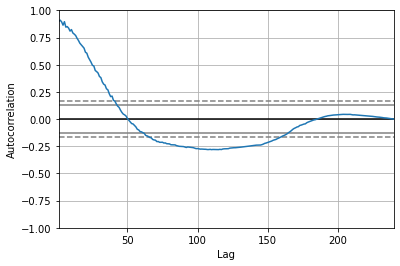

In [7]:
pd.plotting.autocorrelation_plot(death_sequence)

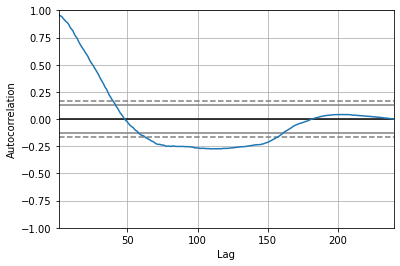

In [8]:
pd.plotting.autocorrelation_plot(case_sequence)

Auto-correlation plot suggests, high correlation among low values of the number of timesteps used to predict the value of the next time-step. Hence, a value of 4 timesteps is initially used.

In [9]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

In [10]:

# choose a number of time steps
n_steps = 4
# convert into input/output
X, y = split_sequence(case_sequence, n_steps)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

In [28]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(LSTM(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 64)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 50)          23000     
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 20)          5680      
_________________________________________________________________
lstm_14 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [30]:
# fit model
model.fit(X, y, epochs=50, verbose=0)

In [31]:
# demonstrate prediction
x_input = array([4044, 2775, 3138, 4072])
#expected number is 3557
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[3568.8186]]


In [33]:
# choose a number of time steps
n_steps = 4
# convert into input/output
X_deaths, y_deaths = split_sequence(death_sequence, n_steps)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X_deaths = X_deaths.reshape((X_deaths.shape[0], n_seq, n_steps, n_features))

In [43]:
model_deaths = Sequential()
model_deaths.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model_deaths.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_deaths.add(TimeDistributed(Flatten()))
model_deaths.add(LSTM(50, activation='relu', return_sequences=True))
model_deaths.add(LSTM(20, activation='relu', return_sequences=True))
model_deaths.add(LSTM(10, activation='relu'))
model_deaths.add(Dense(1))
model_deaths.compile(optimizer='adam', loss='mse')

In [44]:
# fit model_deaths
model_deaths.fit(X_deaths, y_deaths, epochs=100, verbose=0)

In [46]:
# demonstrate prediction
x_input = array([34, 32, 34, 30])
#expected number is 28
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model_deaths.predict(x_input, verbose=0)
print(yhat)

[[35.491943]]
